In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random
import time


In [2]:
   
class Brain:
    def __init__(self, behavior, **kwargs):

        # Params
        self.alpha = kwargs.get('alpha', 0.1)
        self.gamma = kwargs.get('gamma', 0.05)
        self.epsilon = kwargs.get('epsilon', 0.02)
        
        self.time = kwargs.get('time', 1)  #for debugging

        # for convenience
        self.nActions = len(behavior.actionSet)
        self.nStates = len(behavior.stateSet)

        # To be computed
        self.qTable = np.zeros((self.nStates,self.nActions))
        self.oStateInd = behavior.stateInd
        self.oActionInd = None


    def do(self,stateInd):
        self.oStateInd= stateInd
        if(np.random.random() > self.epsilon):
            actionInd = self.exploit(stateInd)
        else:
            actionInd = self.explore()

        self.oActionInd = actionInd
        return self.oActionInd

        

    def learn(self,newstate, reward):
        
        old_q = self.qTable[self.oStateInd,self.oActionInd]
        maxFutureQ = max(self.qTable[newstate, :])

        self.qTable[self.oStateInd, self.oActionInd] = old_q + self.alpha*(reward +                 self.gamma*maxFutureQ - old_q)

# For debugging only
        # delta = self.qTable[self.oStateInd, self.oActionInd] - old_q
        # if self.time%100 == 0:
        #     print(""" delta = {0:.4f} , old q= {1:.3f}, new q = {2:.3f}
        #         """.format(delta,old_q,self.qTable[self.oldStateIndex, self.oldActionIndex]))

        
           
    def exploit(self,stateInd):
        possibleActionValues = self.qTable[stateInd, :]
        maxActionInd = np.where(possibleActionValues == max(possibleActionValues))[0]
        return np.random.choice(maxActionInd)
        
        
    def explore(self):
        return np.random.choice(range(self.nActions))

In [3]:
class Behavior:
    def __init__(self,initState=None,nNutrients = 3, **kwargs):


        self.nNutrients = nNutrients

# Create state and action sets
        self.stateSlicer =  kwargs.get('stateSlicer',5)
        self.actionSlicer =  kwargs.get('actionSlicer', 2)

        tempState = np.linspace(0, 1, self.stateSlicer).round(2)
        #to include space for each nutrient, dynamically add state space for each nutrient
        tempList = np.tile(tempState,(nNutrients,1)) 
        self.stateSet = list(product(*tempList)) 
        
        temp_t = tempState[1]-tempState[0]
        tempAction = np.linspace(-temp_t,temp_t,self.actionSlicer)
        tempList = np.tile(tempAction,(nNutrients,1)) 
        self.actionSet = list(product(*tempList))


        if not initState:
            self.stateInd = np.random.choice(range(len(self.stateSet)))
            print("""randomly initialised to {0} state""".format(self.stateSet[self.stateInd]))
        else:
            state =  initState   #Initializing
            self.stateInd = self.findStateIndex(state)
            print("""initialised to  {0}""".format(state))


        self.stm = np.zeros((len(self.stateSet), len(self.actionSet)))
        self.computeStateTransitions()


        self.output = np.zeros((self.nNutrients))


    def computeStateTransitions(self):
        tic = time.perf_counter()

        for (si,_),(ai,_) in product(enumerate(self.stateSet),enumerate(self.actionSet)):
            nsi = self.updateState(si,ai) 
            self.stm[si,ai] = nsi
        toc = time.perf_counter()

        print("""total time to compute state transition matrix = {0:.2f} seconds""".format(toc-tic))


    def findStateIndex(self,s):
        return np.where((self.stateSet == s).all(axis=1))[0][0]           


    def updateState(self,si,ai):
        s = self.stateSet[si]
        a = self.actionSet[ai]
        #new state defined by behavior based upon action chosen by brain
        ns = np.clip(np.array(s)+np.array(a),0,1).round(2) 
        ind = self.findStateIndex(ns)
        return ind

    def ingestNutrients(self):
        self.output = np.random.binomial(1,self.stateSet[self.stateInd])



In [4]:
class Gut:
    def __init__(self,initPop = None,nBacteria = 3,**kwargs):
        

        self.nBacteria = nBacteria
        self.pop = np.random.choice(np.arange(100,200),self.nBacteria)

        self.gc = kwargs.get('gc',0.1)
        self.dc = kwargs.get('dc',0.1)
        self.K = kwargs.get('K',25000)
        self.bacteriaContri = kwargs.get('bacteriaContri',np.ones((nBacteria)))
            
    ## Population-based implementation
    def updatePopulation(self, nutrients):

        self.pop = self.pop*(1+self.gc*nutrients - self.pop*self.dc/self.K)


    def generateReward(self):

        self.reward = np.sum(self.pop*self.bacteriaContri)
        self.reward = self.reward/(self.gc*self.K/self.dc)
    

In [5]:
behavior = Behavior(stateSlicer = 11,actionSlicer = 2)

randomly initialised to (0.8, 0.4, 0.1) state
total time to compute state transition matrix = 6.31 seconds


In [6]:
brain = Brain(behavior)

gut = Gut()

stepSize = 100
iterations = 10000
n = iterations//stepSize

behaviorHistory = np.zeros((iterations//stepSize,behavior.nNutrients))
gutPopHistory = np.zeros((iterations//stepSize,gut.nBacteria))
rewardHistory = np.zeros((iterations//stepSize))
gut.gc = 0.1
gut.dc = 0.2
gut.bacteriaContri = np.array([1,0,0])
idx=0

# instead of recording system state at fixed intervals, we can also record history at random timesteps
randSel = np.random.randint(0,iterations,n)
randSel.sort()

for t in range(iterations):
    

    # find best possible action in brain using RL
    actionInd = brain.do(behavior.stateInd)
    
    # update behavior state as a result of action chosen by brain
    # old = behavior.stateInd
    newStateInd = behavior.updateState(behavior.stateInd,actionInd)
    behavior.stateInd = newStateInd

    #find the reward elicited by gut
    behavior.ingestNutrients()
    gut.updatePopulation(behavior.output)
    gut.generateReward()
    # print(""" t= {0}
    # old state = {1}, {2}
    # selected action = {3},{4}
    # new state == {5}, {6}
    # nutrients ingested = {7}
    # updated gut population = {8}
    # reward chemicals from gut = {9}
    # """.format(
    #     t
    #     ,old,behavior.stateSet[old]
    #     ,actionInd,behavior.actionSet[actionInd]
    #     ,newStateInd,behavior.stateSet[newStateInd]
    #     ,behavior.output
    #     ,gut.pop
    #     ,gut.reward
    #     ))
    
    
    brain.learn(newStateInd,gut.reward)
    brain.time = t

    # if t%stepSize==0:
    #     print("""{0}th iteration""".format(t))

    #     behaviorHistory[idx] = behavior.output
    #     gutPopHistory[idx] = gut.pop
    #     rewardHistory[idx] = gut.reward
    #     idx+=1

    if idx<n and t==randSel[idx] :
        behaviorHistory[idx] = behavior.output
        gutPopHistory[idx] = gut.pop
        rewardHistory[idx] = gut.reward
        idx+=1


In [7]:
folder = 'simulations/exp5/'

from datetime import datetime
import os,errno

now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


try:
    os.mkdir(folder)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory ',folder,'already exists.')
    else:
        raise

params = """ SIMULATION RAN ON : {dt}
number of iterations = {0}
step size for graphs = {1}

BEHAVIOUR PARAMETERS 
=======================
# nutrients = {b1}
state slicer = {b2}
action slicer = {b3}

shapes of stm, state space, action space = {b4},{b5},{b6}


GUT PARAMETERS
===============
Growth constant = {g1}
Decay constant = {g2}
K = {g3}
per bacteria contribution = {g4}

MORE DETAILS
=========
state space = {b7}
action space = {b8}

LOGS
======
may be add logs if required (later)

""".format(iterations,stepSize
,b1 = behavior.nNutrients,b2 = behavior.stateSlicer,b3 = behavior.actionSlicer
,b4 = behavior.stm.shape,b5 = len(behavior.stateSet),b6 = len(behavior.actionSet)
,b7 = behavior.stateSet,b8 = behavior.actionSet
,g1 = gut.gc,g2 = gut.dc,g3 = gut.K,g4 = gut.bacteriaContri
,dt = dt_string
)

with open(folder+"parameters.txt", "a") as file:
    file.write(params)


Directory  simulations/exp5/ already exists.


Text(0.4, 0.9, 'Individual gut bacteria population evolution')

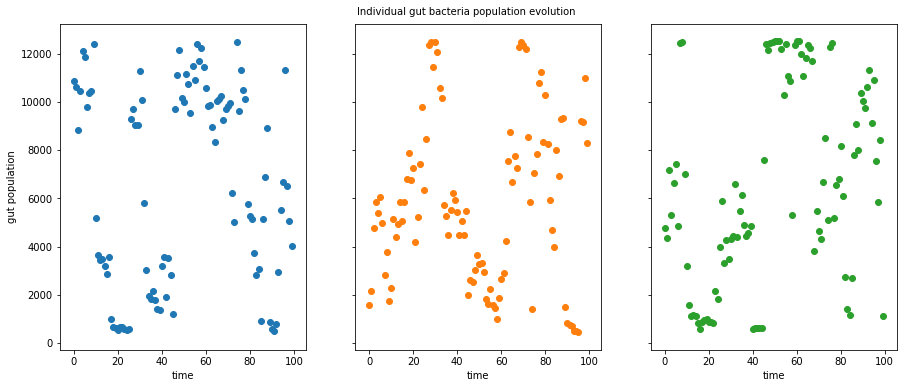

In [8]:
# one scatter plot for each bacterium population. 
# relevant to trace out the population evolution across timesteps.


X = np.arange(gutPopHistory.shape[0])
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharex = True, sharey = True,figsize = (15,6))
cm = plt.get_cmap("tab10")
ax1.scatter(X,gutPopHistory[:,0],color = cm(0))
ax2.scatter(X,gutPopHistory[:,1],color = cm(1))
ax3.scatter(X,gutPopHistory[:,2],color = cm(2))

ax1.set_ylabel("gut population")
ax1.set_xlabel("time")
ax2.set_xlabel("time")
ax3.set_xlabel("time")

fig.text(0.4,0.9,"Individual gut bacteria population evolution")
# plt.savefig(folder+'scatter-per-bact-pop.svg',bbox_inches = 'tight')

Text(0.5, 1.0, 'inidividual gut population of each bacterium with time')

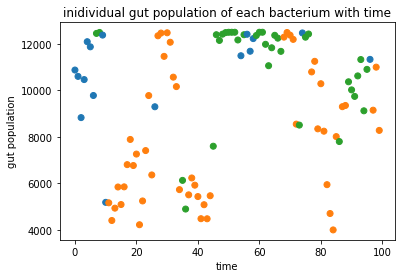

In [9]:
   # plotted the maximum of the three gut bacterial populations at each timestep

cm = plt.get_cmap("tab10")

a = np.argmax(gutPopHistory,axis = 1)
b = np.max(gutPopHistory,axis = 1)
plt.scatter(range(len(a)),b,c = cm(a))
plt.xlabel("time")
plt.ylabel("gut population")
plt.title("inidividual gut population of each bacterium with time")
# plt.savefig(folder+'max-gut-pop-per-timestep.svg',bbox_inches = 'tight',figsize = (20,20))

Text(0, 0.5, 'states')

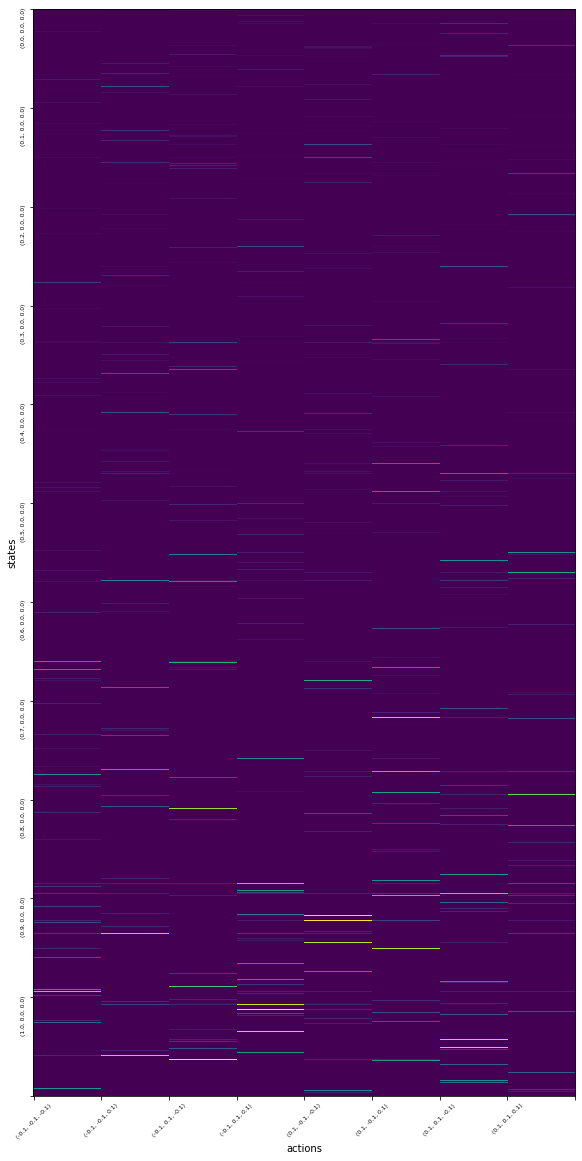

In [10]:
# Qtable heat map


nstates = len(behavior.stateSet)
nactions = len(behavior.actionSet)
expansion = 0.5*nstates//nactions


actions = behavior.actionSet
states = [behavior.stateSet[int(i)] for i in np.linspace(0,nstates,behavior.stateSlicer+1)[:-1]]

fig,ax = plt.subplots(1,1,figsize = (20,20))
ax.imshow(np.repeat(brain.qTable,expansion,1))

ax.set_xticks(np.linspace(0,nactions*expansion-1,nactions+1))
ax.set_xticklabels(actions,rotation = 45,fontsize = 6)

ax.set_yticks(np.linspace(0,nstates,behavior.stateSlicer+1))
ax.set_yticklabels(states,rotation = 90,fontsize = 6)

ax.set_xlabel("actions")
ax.set_ylabel("states")

# plt.savefig(folder+'qtable.svg',bbox_inches = 'tight')

Text(0.3, 0.3, 'time steps (whether with time, nutrients were being ingested or not?)')

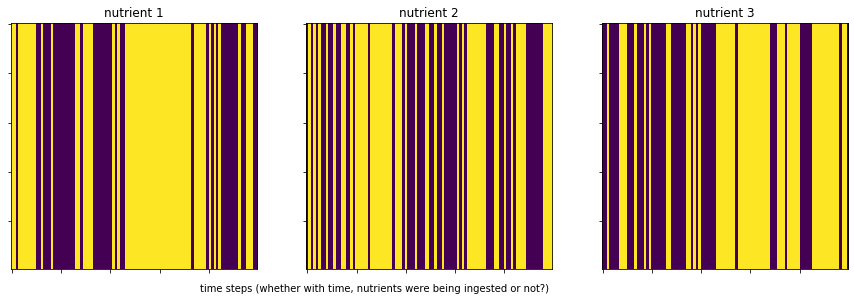

In [11]:
# Behavior history for each bacterium - whether the bacteria received the nutrient or not. 
# yellow represents higher values (or presence od nutrient to the bacteria)

import numpy as np
a = behaviorHistory
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharey = True,sharex = True,figsize = (15,10))
ax1.imshow(np.tile(a[:,0],(n,1)))
ax2.imshow(np.tile(a[:,1],(n,1)))
ax3.imshow(np.tile(a[:,2],(n,1)))
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax1.set_title("nutrient 1")
ax2.set_title("nutrient 2")
ax3.set_title("nutrient 3")
plt.subplots_adjust(wspace=None, hspace=None)
fig.text(0.3,0.3,"time steps (whether with time, nutrients were being ingested or not?)")
# plt.savefig(folder+'nutrient-behavior.svg',bbox_inches = 'tight')

Text(0.5, 1.0, 'stacked gut population')

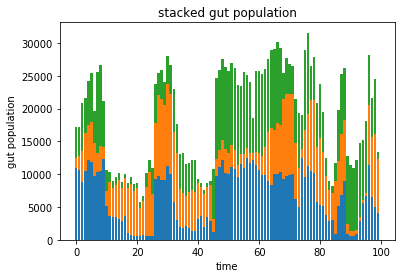

In [12]:
# Gut population stacked bar chart
# this one is pretty expensive chart, run it only with small datasets.
n = 100
X = np.arange(n)
plt.bar(X,gutPopHistory[:n,0])
plt.bar(X,gutPopHistory[:n,1],bottom = gutPopHistory[:n,0])
plt.bar(X,gutPopHistory[:n,2],bottom = np.sum(gutPopHistory[:n,:2],axis = 1))
plt.xlabel("time")
plt.ylabel("gut population")
plt.title("stacked gut population")
# plt.savefig(folder+'stacked-bar-gut-pop.svg',bbox_inches = 'tight')


Text(0, 0.5, 'normalized reward')

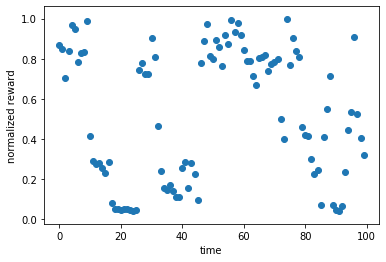

In [13]:
# plotting reward history

plt.scatter(range(len(rewardHistory)),rewardHistory)
plt.xlabel("time")
plt.ylabel("normalized reward")